In [7]:
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt
import math
from datetime import datetime
import time
import pickle

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Setting global variables

In [8]:
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_CUDNN_DETERMINISM'] = str(1)
SEED = 443
NUMPY_FOLDER = 'full_repo/ex_4'

### Supporting functions

In [9]:
def set_seeds():
    # Set seed to produce comparable experiments
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    rn.seed(SEED)

In [10]:
# Create and compile combined model
def create_model(shape_train_data_mfcc, shape_train_data_raw):
    set_seeds()
    # MFCC branch
    input_tensor_mfcc = Input(shape=(shape_train_data_mfcc), name='MFCC')
    x = Conv2D(64, (3, 3), padding='valid', activation='relu')(input_tensor_mfcc)
    x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D((2 ,2))(x)
    x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D((2 ,2))(x)
    x = Flatten()(x)
    x = Dropout(0.25, seed=SEED)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25, seed=SEED)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2, seed=SEED)(x)

    set_seeds()
    # Raw wave branch
    input_tensor_raw = Input(shape=(shape_train_data_raw), name='RawWave')
    y = Conv1D(64, 9, padding='same', activation='relu')(input_tensor_raw)
    y = Conv1D(64, 9, padding='same', activation='relu')(y)
    y = MaxPooling1D((7))(y)
    y = Conv1D(128, 9, padding='same', activation='relu')(y)
    y = Conv1D(128, 9, padding='same', activation='relu')(y)
    y = MaxPooling1D((7))(y)
    y = Conv1D(256, 9, padding='same', activation='relu')(y)
    y = Conv1D(256, 9, padding='same', activation='relu')(y)
    y = MaxPooling1D((5))(y)
    y = Flatten()(y)
    y = Dropout(0.4, seed=SEED)(y)
    y = Dense(128, activation='relu')(y)
    y = Dropout(0.4, seed=SEED)(y)
    
    concatenated = concatenate([x, y], axis=-1)
    output_tensor = Dense(33, activation='softmax')(concatenated)
    
    model = Model([input_tensor_mfcc, input_tensor_raw], output_tensor)
    #model.summary()
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [11]:
# Fit model
def model_fit(model_build, train_data_mfcc, train_data_raw, train_labels, val_data_mfcc, val_data_raw, val_labels):    
    set_seeds()
    # Use earlystopping, with validation accuracy as metrics
    model_checkpoint_name = "saved_models/model_cp_" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    callbacks = [
        EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1),
        ModelCheckpoint(model_checkpoint_name+'.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
    ]
    history = model_build.fit([train_data_mfcc, train_data_raw],
              train_labels,
              epochs=25,
              batch_size=128,
              validation_data=([val_data_mfcc, val_data_raw], val_labels),
              callbacks=callbacks)
    return model_build, history

### Get data and create models

In [13]:
# Get data from npy-files generated in the preprocessing-step (create_tensors.py)
dataset_train = []
dataset_train.append(['Noise_SNR_Dynamic', 
                      'train_data_raw_noise_dyn',
                      'train_data_mfcc_noise_dyn', 
                      'train_labels',
                      'val_data_raw_noise_dyn',
                      'val_data_mfcc_noise_dyn',
                      'val_labels'
                     ])
dataset_train.append(['No_noise', 
                      'train_data_raw_no_noise', 
                      'train_data_mfcc_no_noise', 
                      'train_labels',
                      'val_data_raw_no_noise',
                      'val_data_mfcc_no_noise',
                      'val_labels'
                     ])

# The validation and testdata
dataset_val_no_noise = ['val_data_raw_no_noise', 'val_data_mfcc_no_noise', 'val_labels']
dataset_val_noise_dyn = ['val_data_raw_noise_dyn', 'val_data_mfcc_noise_dyn', 'val_labels']
dataset_test_no_noise = ['test_data_raw_no_noise', 'test_data_mfcc_no_noise', 'test_labels']
dataset_test_5_6 = ['test_data_raw_5_6', 'test_data_mfcc_5_6', 'test_labels']
dataset_test_6 = ['test_data_raw_6', 'test_data_mfcc_6', 'test_labels']

# Test data no noise
data_test_raw_no_noise = np.load(NUMPY_FOLDER+'/test_data_raw_no_noise.npy')
data_test_mfcc_no_noise = np.load(NUMPY_FOLDER+'/test_data_mfcc_no_noise.npy')
data_test_labels = np.load(NUMPY_FOLDER+'/test_labels.npy')
print(data_test_raw_no_noise.shape, data_test_mfcc_no_noise.shape, data_test_labels.shape, "test data")

# Test data 5_6
data_test_raw_5_6 = np.load(NUMPY_FOLDER+'/test_data_raw_5_6.npy')
data_test_mfcc_5_6 = np.load(NUMPY_FOLDER+'/test_data_mfcc_5_6.npy')
data_test_labels = np.load(NUMPY_FOLDER+'/test_labels.npy')
print(data_test_raw_5_6.shape, data_test_mfcc_5_6.shape, data_test_labels.shape, "test data")

# Test data 6
data_test_raw_6 = np.load(NUMPY_FOLDER+'/test_data_raw_6.npy')
data_test_mfcc_6 = np.load(NUMPY_FOLDER+'/test_data_mfcc_6.npy')
data_test_labels = np.load(NUMPY_FOLDER+'/test_labels.npy')
print(data_test_raw_6.shape, data_test_mfcc_6.shape, data_test_labels.shape, "test data")

# Validation data no noise
data_val_raw_no_noise = np.load(NUMPY_FOLDER+'/val_data_raw_no_noise.npy')
data_val_mfcc_no_noise = np.load(NUMPY_FOLDER+'/val_data_mfcc_no_noise.npy')
data_val_labels = np.load(NUMPY_FOLDER+'/val_labels.npy')
print(data_val_raw_no_noise.shape, data_val_mfcc_no_noise.shape, data_val_labels.shape, "validation data")

# Validation data noise dynamic
data_val_raw_noise_dyn = np.load(NUMPY_FOLDER+'/val_data_raw_noise_dyn.npy')
data_val_mfcc_noise_dyn = np.load(NUMPY_FOLDER+'/val_data_mfcc_noise_dyn.npy')
data_val_labels = np.load(NUMPY_FOLDER+'/val_labels.npy')
print(data_val_raw_noise_dyn.shape, data_val_mfcc_noise_dyn.shape, data_val_labels.shape, "validation data")

history_data = {}

# Train the models and store the results
for files in dataset_train:
    print(f"Training model on {files[0]} data.")
    # Fetch data from folder
    train_data_raw = np.load(NUMPY_FOLDER+'/'+files[1]+'.npy')
    train_data_mfcc = np.load(NUMPY_FOLDER+'/'+files[2]+'.npy')
    train_data_labels = np.load(NUMPY_FOLDER+'/'+files[3]+'.npy')
    val_data_raw = np.load(NUMPY_FOLDER+'/'+files[4]+'.npy')
    val_data_mfcc = np.load(NUMPY_FOLDER+'/'+files[5]+'.npy')
    val_data_labels = np.load(NUMPY_FOLDER+'/'+files[6]+'.npy')
    
    
    print("Loaded", files, train_data_raw.shape, train_data_mfcc.shape, train_data_labels.shape, "\n")
    
    # Build and train model
    try:
        model = create_model(train_data_mfcc[0].shape, train_data_raw[0].shape)
    except:
        print("Failed to create model!", files[0])
    try:
        model, history = model_fit(model, 
                                   train_data_mfcc, 
                                   train_data_raw, 
                                   train_data_labels, 
                                   val_data_mfcc, 
                                   val_data_raw, 
                                   val_data_labels
                                  )

        # Evaluate model on test data
        result_no_noise = model.evaluate([data_test_mfcc_no_noise, data_test_raw_no_noise], data_test_labels)
        result_5_6 = model.evaluate([data_test_mfcc_5_6, data_test_raw_5_6], data_test_labels)
        result_6 = model.evaluate([data_test_mfcc_6, data_test_raw_6], data_test_labels)
        print("Evaluation of three test sets:")
        print("Test set, no noise", result_no_noise)
        print("Test set, noise 5_6", result_5_6)
        print("Test set, noise 6", result_6)
    except:
        print("Failed to train model of type", files[0])

    # Save model
    try:
        model_name = "model_ex_3_" + files[0] + "_" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        model.save('saved_models/'+model_name)
    except:
        print("Failed to save model of type", files[0])
    
    # Store graph data
    history_data[files[0]] = history.history

# Store history data on disk
history_store = open("history_"+datetime.now().strftime("%Y-%m-%d_%H:%M:%S")+".pkl", "wb")
pickle.dump(history_data, history_store)
history_store.close()

(5084, 8000, 1) (5084, 20, 45, 1) (5084, 33) test data
(5084, 8000, 1) (5084, 20, 45, 1) (5084, 33) test data
(5084, 8000, 1) (5084, 20, 45, 1) (5084, 33) test data
(5093, 8000, 1) (5093, 20, 45, 1) (5093, 33) validation data
(5093, 8000, 1) (5093, 20, 45, 1) (5093, 33) validation data
Training model on Noise_SNR_Dynamic data.
Loaded ['Noise_SNR_Dynamic', 'train_data_raw_noise_dyn', 'train_data_mfcc_noise_dyn', 'train_labels', 'val_data_raw_noise_dyn', 'val_data_mfcc_noise_dyn', 'val_labels'] (40677, 8000, 1) (40677, 20, 45, 1) (40677, 33) 

Epoch 1/25
318/318 [==============================] - ETA: 0s - loss: 2.5840 - accuracy: 0.2557
Epoch 00001: val_accuracy improved from -inf to 0.57883, saving model to saved_models/model_cp_2021-12-10_15:48:34.hdf5
318/318 [==============================] - 65s 205ms/step - loss: 2.5840 - accuracy: 0.2557 - val_loss: 1.4037 - val_accuracy: 0.5788
Epoch 2/25
318/318 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.6221
Epoch 

### Graph training process

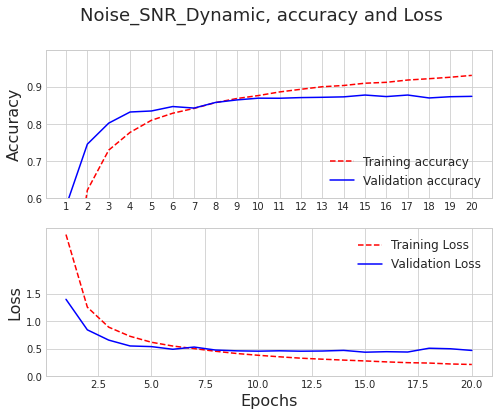

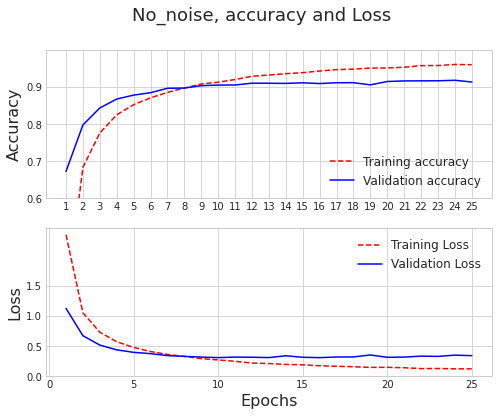

In [14]:
for model_name, history in history_data.items():
    # Prepare performance graph, without noisy data
    plt.style.use('seaborn-whitegrid')
    history_dict = history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(loss) + 1)
    
    #plt.clf()
    fig, ax = plt.subplots(2, figsize=(8,6))
    fig.suptitle(model_name+", accuracy and Loss", fontsize=18)
    ax[0].plot(epochs, acc, '--r', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_xticks(epochs)
    ax[0].set_yticks(np.arange(0.0, 1.0, step=0.1))
    ax[0].set_ylabel("Accuracy", fontsize=16)
    ax[0].set_ylim(0.6, 1.0)

    ax[1].plot(epochs, loss, '--r', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_yticks(np.arange(0.0, 2.0, step=0.5))
    ax[1].set_ylabel("Loss", fontsize=16)
    ax[1].set_xlabel("Epochs", fontsize=16)

    ax[0].legend(fontsize=12, loc='lower right')
    ax[1].legend(fontsize=12, loc='upper right')
    plt.show

### Other code

[[ 0.43540859]
 [-0.05192361]
 [-0.00824253]
 ...
 [ 0.0835233 ]
 [ 0.09305996]
 [ 0.03813611]]


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 432x288 with 0 Axes>

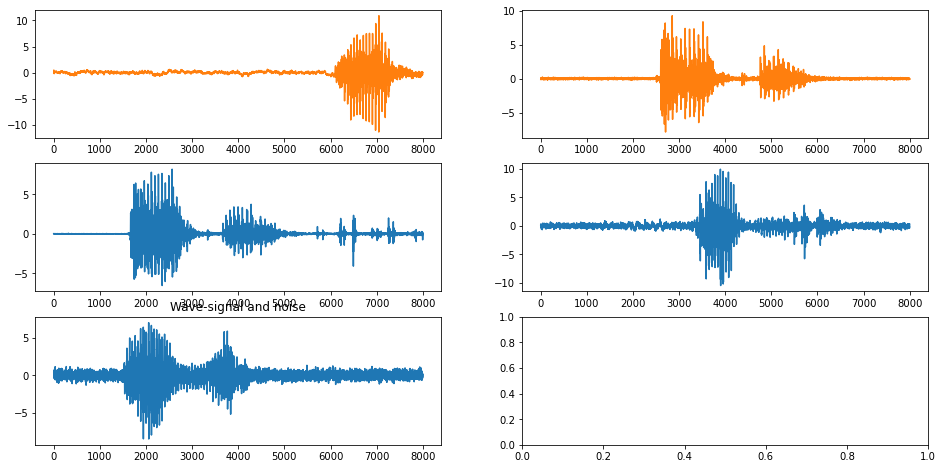

In [22]:
some = np.load('full_repo/ex_4/train_data_raw_noise_dyn.npy')
print(some[0])
plt.plot(some[0])

plt.clf()
fig, ax = plt.subplots(3,2, figsize=(16, 8))

ax[0, 0].plot(some[0], 'tab:orange')
ax[0, 1].plot(some[1] , 'tab:orange')

ax[1, 0].plot(some[2])
ax[1, 1].plot(some[3], 'tab:blue')

ax[2, 0].plot(some[4], 'tab:blue')
ax[2, 0].set_title('Wave-signal and noise')
plt.show